In [35]:
%matplotlib inline


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from matplotlib.lines import Line2D

import matplotlib.ticker as tck


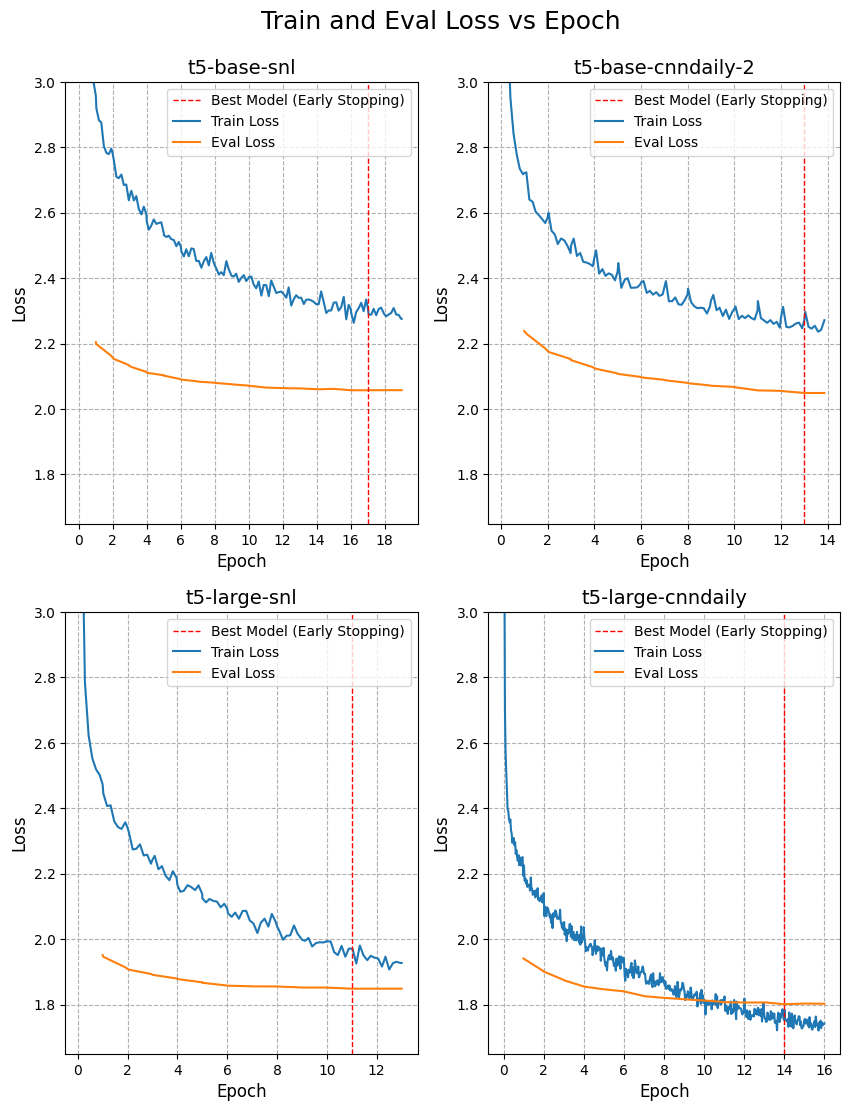

In [249]:
runs = [
    {"model_name": "t5-base-snl", "wandb_url": "/navjordj/huggingface/runs/70ow8xqt"},
    {"model_name": "t5-base-cnndaily-2", "wandb_url": "/navjordj/huggingface/runs/6b3n44zi"},
    {"model_name": "t5-large-snl", "wandb_url": "/navjordj/huggingface/runs/zoy0w9hk"},
    {"model_name": "t5-large-cnndaily", "wandb_url": "/navjordj/huggingface/runs/zrx32j09"},
]

api = wandb.Api()

fig, axes = plt.subplots(2, 2, figsize=(10, 12))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12



plt.style.use('default')

for i, run_info in enumerate(runs):
    run = api.run(run_info["wandb_url"]).history()
    run = run.drop(run.tail(1).index)



    run["train/loss"] = run["train/loss"].interpolate(method="linear")
    run["eval/loss"] = run["eval/loss"].interpolate(method="linear")

    ax = axes[i // 2, i % 2]

    ax.xaxis.set_major_locator(tck.MultipleLocator(2))


    train_loss_line = ax.plot(run["train/epoch"], run["train/loss"], label="Train Loss", linewidth=1.5)
    eval_loss_line = ax.plot(run["train/epoch"], run["eval/loss"], label="Eval Loss", linewidth=1.5)

    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.set_title(f"{run_info['model_name']}", fontsize=14)

    ax.set_ylim(1.65, 3)

    ax.grid(True, linestyle="--", alpha=1)

    # Add a vertical line at the epoch corresponding to the minimum value of eval/loss
    min_eval_loss_index = run["eval/loss"].idxmin()
    min_eval_loss_epoch = run.loc[min_eval_loss_index, "train/epoch"]
    best_model_line = ax.axvline(min_eval_loss_epoch, color="red", linestyle="--", linewidth=1, alpha=1)

    custom_lines = [Line2D([0], [0], color='red', linestyle='--', lw=1),
                    Line2D([0], [0], color=train_loss_line[0].get_color(), lw=1.5),
                    Line2D([0], [0], color=eval_loss_line[0].get_color(), lw=1.5),
                    ]

    ax.legend(custom_lines, ['Best Model (Early Stopping)', 'Train Loss', 'Eval Loss', ], loc='upper right', fontsize=10)

# Add a single title for the entire figure
plt.suptitle("Train and Eval Loss vs Epoch", fontsize=18)
plt.subplots_adjust(top=0.92)
#plt.tight_layout()
plt.savefig("train_losses.png")
plt.show()


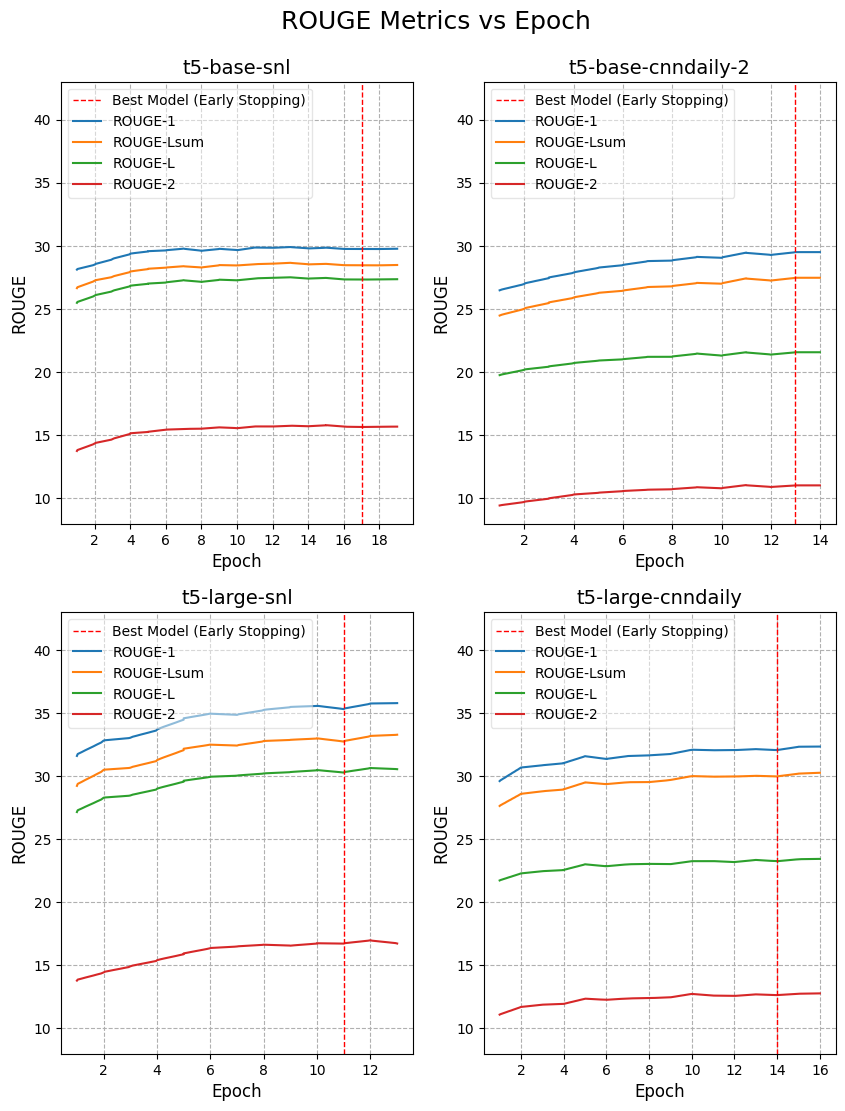

In [2]:
runs = [    {"model_name": "t5-base-snl", "wandb_url": "/navjordj/huggingface/runs/70ow8xqt"},    {"model_name": "t5-base-cnndaily-2", "wandb_url": "/navjordj/huggingface/runs/6b3n44zi"},    {"model_name": "t5-large-snl", "wandb_url": "/navjordj/huggingface/runs/zoy0w9hk"},    {"model_name": "t5-large-cnndaily", "wandb_url": "/navjordj/huggingface/runs/zrx32j09"},]

api = wandb.Api()

fig, axes = plt.subplots(2, 2, figsize=(10, 12))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.style.use('default')

for i, run_info in enumerate(runs):
    run = api.run(run_info["wandb_url"]).history()

    last_epoch = run["train/epoch"].iloc[-1]

    
    # Noe som var merkelig med siste verdi på ROUGE-scorene her. på wandb.ai er det riktig 🤷‍♂️
    if run_info["model_name"] == "t5-base-snl":
        for metric in ['eval/rouge1', 'eval/rouge2', 'eval/rougeL', 'eval/rougeLsum']:
            last_non_nan_value = run[metric].dropna().iloc[-2]
            run.loc[run["train/epoch"] == last_epoch, metric] = last_non_nan_value



    for metric in ['eval/rouge1', 'eval/rougeLsum', 'eval/rougeL', 'eval/rouge2']:
        run[metric] = run[metric].interpolate(method="linear")

    ax = axes[i // 2, i % 2]

    ax.xaxis.set_major_locator(tck.MultipleLocator(2))

    metric_lines = []
    for metric in['eval/rouge1', 'eval/rougeLsum', 'eval/rougeL', 'eval/rouge2']:
        metric_line = ax.plot(run["train/epoch"], run[metric], label=metric, linewidth=1.5)
        metric_lines.append(metric_line)
    
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("ROUGE", fontsize=12)
    ax.set_title(f"{run_info['model_name']}", fontsize=14)

    ax.set_ylim(8, 43)


    ax.grid(True, linestyle="--", alpha=1)

    # Add a vertical line at the epoch corresponding to the maximum value of eval/rougeL
    min_eval_loss_index = run["eval/loss"].idxmin()
    min_eval_loss_epoch = run.loc[min_eval_loss_index, "train/epoch"]
    best_model_line = ax.axvline(min_eval_loss_epoch, color="red", linestyle="--", linewidth=1, alpha=1)

    custom_lines = [Line2D([0], [0], color='red', linestyle='--', lw=1)]
    for i, metric in enumerate(['eval/rouge1', 'eval/rouge2', 'eval/rougeL', 'eval/rougeLsum']):
        
        line = Line2D([0], [0], color=metric_lines[i][0].get_color(), lw=1.5)
        custom_lines.append(line)

    leg = ax.legend(custom_lines, ['Best Model (Early Stopping)', 'ROUGE-1', 'ROUGE-Lsum', 'ROUGE-L', 'ROUGE-2'], framealpha=0.5, loc='upper left', fontsize=10)



#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines[:4], labels[:4], loc='upper right', ncol=1, fontsize=14)


# Add a single title for the entire figure
plt.suptitle("ROUGE Metrics vs Epoch", fontsize=18)
plt.subplots_adjust(top=0.92)
#plt.tight_layout()
plt.savefig("rouge_eval_metrics.png")
plt.show()


In [3]:
# Single plot for ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum


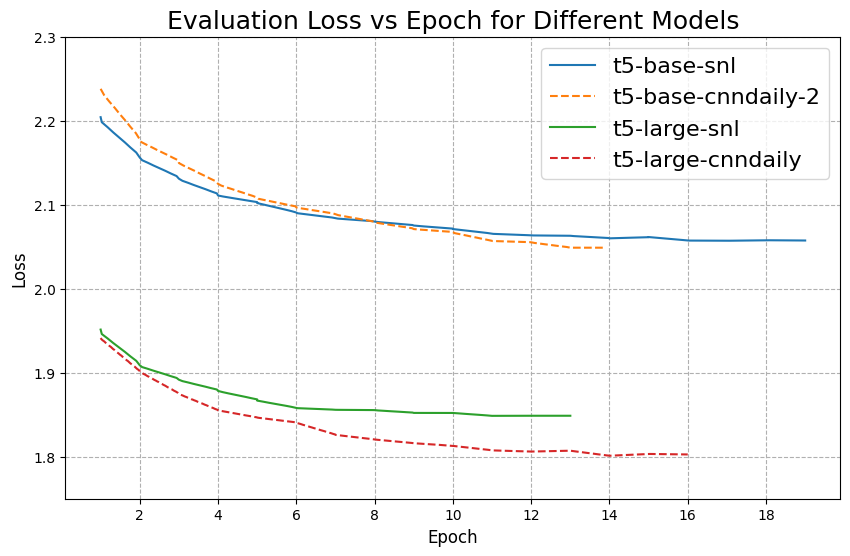

In [16]:
runs = [
    {"model_name": "t5-base-snl", "wandb_url": "/navjordj/huggingface/runs/70ow8xqt"},
    {"model_name": "t5-base-cnndaily-2", "wandb_url": "/navjordj/huggingface/runs/6b3n44zi"},
    {"model_name": "t5-large-snl", "wandb_url": "/navjordj/huggingface/runs/zoy0w9hk"},
    {"model_name": "t5-large-cnndaily", "wandb_url": "/navjordj/huggingface/runs/zrx32j09"},
]

api = wandb.Api()

fig, ax = plt.subplots(figsize=(10, 6))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.style.use('default')

line_styles = ['-', '--', '-', '--']

color_idx = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, run_info in enumerate(runs):
    run = api.run(run_info["wandb_url"]).history()
    run = run.drop(run.tail(1).index)

    run["eval/loss"] = run["eval/loss"].interpolate(method="linear")

    ax.xaxis.set_major_locator(tck.MultipleLocator(2))

    eval_loss_line = ax.plot(run["train/epoch"], run["eval/loss"], label=f"{run_info['model_name']} Eval Loss", linewidth=1.5, linestyle=line_styles[i], color=colors[color_idx])

    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.set_ylim(1.75, 2.3)

    ax.grid(True, linestyle="--", alpha=1)

    color_idx += 1

custom_lines = [Line2D([0], [0], color=colors[i], linestyle=line_styles[i], lw=1.5) for i in range(len(runs))]
labels = [f"{run_info['model_name']}" for run_info in runs]

ax.legend(custom_lines, labels, loc='upper right', fontsize=16)

# Add a single title for the entire figure
plt.title("Evaluation Loss vs Epoch for Different Models", fontsize=18)

plt.savefig("eval_losses_combined_simplified_corrected_legend.png")
plt.show()
